In [1]:
# !pip install tensorflow==1.15.0
# !pip install scikit-optimize

In [2]:
import numpy as np
import pandas as pd
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl

In [3]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args

In [4]:
randomState = 42
np.random.seed(randomState)
tf.set_random_seed(randomState)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
raw10 = pd.read_csv('/content/gdrive/MyDrive/SoilMoisture/Data/c_5_data_soil_50.csv')
df10 = raw10.copy()

df10 = df10.rename(columns={'In-Situ':'InSitu'})

def replace_missing(attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df10['NDVI'])
replace_missing(df10['EVI'])
replace_missing(df10['LSTDay'])
replace_missing(df10['LSTNight'])

df10 = df10.dropna()
df10.isnull().sum()

Precip       0
NDVI         0
EVI          0
GPP          0
LSTDay       0
LSTNight     0
Elevation    0
RZSM         0
SURFSM       0
Clay         0
Sand         0
Silt         0
BD           0
InSitu       0
dtype: int64

In [7]:
df10['group'] = df10['Sand'].ne(df10['Sand'].shift()).cumsum()
df10 = df10.groupby('group')
dfs = []
for name, data in df10:
    dfs.append(data)

In [8]:
train_dataset = pd.DataFrame()
val_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()

for df in dfs:
    df.pop('group')
    train_size = int(len(df)*0.8)
    val_size = int(len(df)*0.9)
    train, val, test = df.iloc[:train_size], df.iloc[train_size:val_size], df.iloc[val_size:]
    train_dataset = train_dataset.append(train)
    val_dataset = val_dataset.append(val)
    test_dataset = test_dataset.append(test)

In [9]:
# Split X
X_train = train_dataset.drop('InSitu', axis = 1)
X_val = val_dataset.drop('InSitu', axis = 1)
X_test = test_dataset.drop('InSitu', axis = 1)

# Split y
y_train = train_dataset.loc[:,['InSitu']]
y_val = val_dataset.loc[:,['InSitu']]
y_test = test_dataset.loc[:,['InSitu']]

In [10]:
# Fit the scaler using available training data
input_scaler = StandardScaler().fit(X_train)

# Apply the scaler to training data
x_train = input_scaler.transform(X_train)
x_val = input_scaler.transform(X_val)
x_test = input_scaler.transform(X_test)

x_train = np.array(x_train, np.float32)
y_train = np.array(y_train, np.float32)

x_val = np.array(x_val, np.float32)
y_val = np.array(y_val, np.float32)

x_test = np.array(x_test, np.float32)
y_test = np.array(y_test, np.float32)

y_train = y_train.reshape((y_train.size, 1))
y_val = y_val.reshape((y_val.size, 1))
y_test = y_test.reshape((y_test.size, 1))

In [11]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=2, high=4, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=128, high=512, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid'], name='activation')

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]


default_parameters = [1e-3, 2, 256, 'relu']

In [12]:
# To log traning progress
def log_dir_name(learning_rate, num_dense_layers, num_dense_nodes, activation):
    # dir-name for TensorBoard log-dir.
    s = "/content/gdrive/MyDrive/SoilMoisture/DNNlogs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}"
    log_dir = s.format(learning_rate, num_dense_layers, num_dense_nodes, activation)

    return log_dir

In [13]:
#To create model with determined hyperparameters
def create_model(learning_rate, num_dense_layers, num_dense_nodes, activation):
    model = Sequential()
    model.add(InputLayer(input_shape=(x_train.shape[1])))
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        # add dense layer
        model.add(Dense(num_dense_nodes, activation=activation, name=name))
    model.add(Dense(1, activation='linear'))
    # Adam optimizer
    optimizer = Adam(lr=learning_rate)  
    #compile the model
    model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

path_best_model = '/content/gdrive/MyDrive/SoilMoisture/DNN_Models/DNN_50_best_model.h5'
validation_data = (x_val, y_val)
best_loss = 5.0

In [14]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate: Learning-rate for the optimizer.
    num_layers:    Number of LSTM layers.
    num_nodes:     Number of nodes in each LSTM layer.
    Activation:    Activation Type.
    """
    # Print the hyper-parameters
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()   
    # Create the LSTM
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)
    # Dir-name for TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers, num_dense_nodes, activation)
    #callback
    callback_log = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
    # Use Keras to train the model.
    history = model.fit(x= x_train,
                        y= y_train,
                        epochs=30,
                        batch_size=128,
                        validation_data=validation_data,
                        callbacks=[callback_log])

    loss = history.history['val_loss'][-1]

    print()
    print("MSE Loss:", loss)
    print()

    global best_loss

    if loss < best_loss:
        # Save the new model
        model.save(path_best_model)
        best_loss = loss

    del model
    
    K.clear_session()
    
    return loss

In [15]:
start = time.time()
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',          # Expected Improvement.
                            n_calls=75,
                            x0=default_parameters)
print("Optimization Run Time: ", (time.time()-start)/60)

Streaming output truncated to the last 5000 lines.
Epoch 21/30
36617/36617 [==============================] - 1s 16us/sample - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 22/30
36617/36617 [==============================] - 1s 16us/sample - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 23/30
36617/36617 [==============================] - 1s 16us/sample - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 24/30
36617/36617 [==============================] - 1s 16us/sample - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 25/30
36617/36617 [==============================] - 1s 16us/sample - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 26/30
36617/36617 [==============================] - 1s 16us/sample - loss: 0.0064 - mean_squ

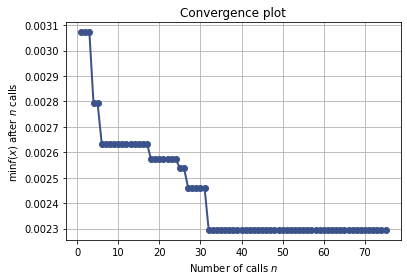

In [16]:
plot_convergence(search_result) 

In [17]:
#best hyperparameters
print("Best Hyperparameters: ",search_result.x)

#corr. result
print(search_result.fun)

Best Hyperparameters:  [0.009918516915338321, 4, 133, 'sigmoid']
0.0022947662131507208


In [18]:
#All Results
sorted(zip(search_result.func_vals, search_result.x_iters))

[(0.0022947662131507208, [0.009918516915338321, 4, 133, 'sigmoid']),
 (0.0024609766552183654, [0.00860966698405206, 4, 134, 'relu']),
 (0.0025061023979524493, [0.009172132538571014, 2, 496, 'relu']),
 (0.0025386154076915907, [0.009243995582916352, 4, 509, 'relu']),
 (0.002547745811326687, [0.009808030899013666, 2, 504, 'relu']),
 (0.0025647483841213506, [0.009448301352212484, 2, 507, 'relu']),
 (0.00257201980199581, [0.009437716722805122, 2, 509, 'relu']),
 (0.0026050918678691424, [0.009889648716588931, 2, 132, 'relu']),
 (0.0026147666080820853, [0.008900599867593817, 4, 128, 'relu']),
 (0.0026339022069823536, [0.0020779564906670653, 4, 257, 'relu']),
 (0.002681218534868771, [0.0095977923566401, 4, 139, 'relu']),
 (0.002695025434869738, [0.009556301765618022, 4, 132, 'relu']),
 (0.002703867689243471, [0.0094319139139628, 4, 145, 'relu']),
 (0.0027288733899140816, [0.009355531505690585, 2, 140, 'relu']),
 (0.0027477093945813473, [0.008685533444568964, 2, 510, 'relu']),
 (0.0027525318071

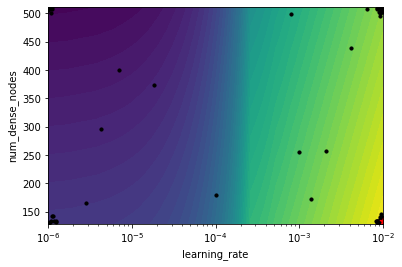

In [19]:
from skopt.plots import plot_objective_2D
fig = plot_objective_2D(result=search_result,
                        dimension_identifier1='learning_rate',
                        dimension_identifier2='num_dense_nodes',
                        levels=50)

ok


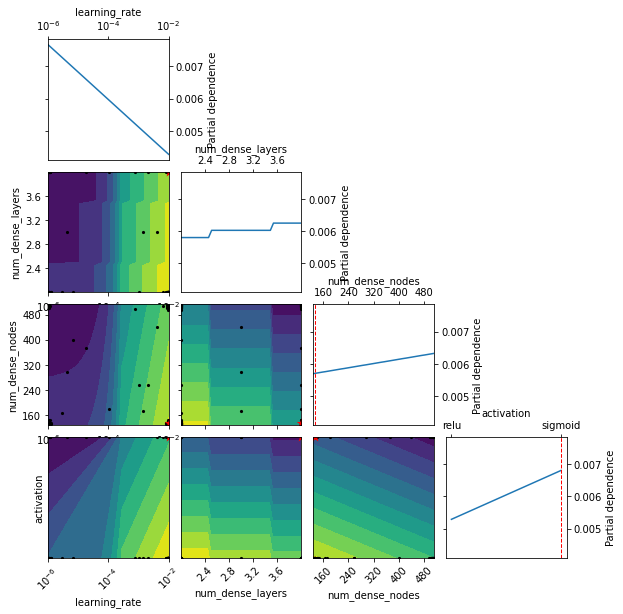

In [20]:
# create a list for plotting
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'activation' ]

try:
  fig, ax = plot_objective(result=search_result, dimensions=dim_names)
except:
  print("ok")

In [21]:
try:
  best_model= load_model(path_best_model)
except:
  print("ok")

ok


In [22]:
opt_par = search_result.x

# use hyper-parameters from optimization
learning_rate = opt_par[0]
num_dense_layers = opt_par[1]
num_dense_nodes = opt_par[2]
activation = opt_par[3]

model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1])))
for i in range(num_dense_layers):
    name = 'layer_dense_{0}'.format(i+1)
    # add dense layer
    model.add(Dense(num_dense_nodes, activation=activation, name=name))
model.add(Dense(1, activation='linear'))

optimizer = Adam(lr=learning_rate)
model.summary()
model.compile(optimizer=optimizer, loss='MSE', metrics=[tf.keras.metrics.MeanSquaredError()])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(x_train, y_train, validation_data=(x_val,y_val), callbacks=[monitor],verbose=2,epochs=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_dense_1 (Dense)        (None, 133)               1862      
_________________________________________________________________
layer_dense_2 (Dense)        (None, 133)               17822     
_________________________________________________________________
layer_dense_3 (Dense)        (None, 133)               17822     
_________________________________________________________________
layer_dense_4 (Dense)        (None, 133)               17822     
_________________________________________________________________
dense (Dense)                (None, 1)                 134       
Total params: 55,462
Trainable params: 55,462
Non-trainable params: 0
_________________________________________________________________
Train on 36617 samples, validate on 4577 samples
Epoch 1/100
36617/36617 - 2s - loss: 0.0177 - mean_squared_error: 0.0

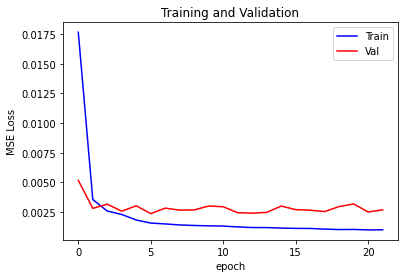

In [23]:
plt.plot(histories.history['loss'], 'b')
plt.plot(histories.history['val_loss'],'r' )
plt.title('Training and Validation')
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('/content/gdrive/MyDrive/SoilMoisture/DNN_Images/MSE_c5_50.png', dpi=400)
plt.show()